# 无模型时序差分控制（Model-Free TD Control）


**on-policy & off-policy**:on-policy, Learn about policy $\pi$(target policy) from experience sampled from $\pi$; off-policy，Learn about policy $\pi$ from experience sampled from $\mu$(behavior policy)


- 行为策略（behavior policy）：
- 用于生成行动策略被称为**行动策略**。行为策略可能和实际上被评估和改善的策略无关。
- 被评估和改善的策略被称为**目标策略**

首先我们称采样数据的策略为行为策略（behavior policy），称用这些数据来更新的策略为目标策略（target policy）。

**在线策略（on-policy）**方法指的是行为策略和目标策略是同一个策略；而**离线策略（off-policy）**方法指的是行为策略和目标策略不是同一个策略。Sarsa 是典型的在线策略算法，而 Q-learning 是典型的离线策略算法。


Q-learning的更新公式：

$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \left[ r_{t} + \gamma \max_{a\in \mathcal{A}}Q(s_{t+1},a_t) - Q(s_t,a_t) \right]
$$

Sarsa的更新公式:

$$
Q\left(s_{t}, a_{t}\right) \leftarrow Q\left(s_{t}, a_{t}\right)+\alpha\left[r_{t}+\gamma Q\left(s_{t+1}, a_{t+1}\right)-Q\left(s_{t}, a_{t}\right)\right]
$$

动作价值的函数的贝尔曼最优方程式:
$$
Q_{*}(s, a)=r(s, a)+\gamma \sum_{s^{\prime} \in \mathcal{S}} p\left(s^{\prime} \mid s, a\right) \max _{a^{\prime}} Q_{*}\left(s^{\prime}, a^{\prime}\right)
$$

**注意：**

即 Q-learning 是直接在估计$Q_{*}$,而 Sarsa 是在估计当前$\epsilon$-greedy 策略的动作价值函数。需要强调的是 Q-learning 的更新并非必须使用当前贪心策略的$argmaxQ$采样得到的数据，因为是给定任意的$(s,a,s^\prime)$都可以直接根据更新公式来更新Q

而 Sarsa 必须使用当前$\epsilon$-greedy 策略采样得到的数据，因为它的更新中用到的 $Q_{*}\left(s^{\prime}, a^{\prime}\right)$是在当前策略下在$s^{\prime}$的动作。

我们称 Sarsa 是在线策略（on-policy）算法，称 Q-learning 是离线策略（off-policy）算法
## Cliff Walking
![](https://gitee.com/wubmu/image/raw/master/img/20210823214810.png)

Cliff Walking 是一个非常经典的强化学习环境，它要求一个智能体从起点出发，避开悬崖行走，最终到达目标位置。如图所示，有一个 的网格世界，每一个网格是一个状态，起点是左下角的状态，目标是右下角的状态。智能体在每一个状态都可以采取 4 种动作：上,下,左,右，如果采取动作后触碰到边界墙壁则状态不发生改变，否则就会相应到达下一个状态。其中有一段悬崖，智能体到达目标状态或掉入悬崖都会结束并回到起点，也就是说它们是终止状态。每走一步的奖励是-1，掉入悬崖的奖励是-100。

In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # tqdm是显示循环进度条的库


In [2]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0 # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1 # 记录当前智能体位置的纵坐标
        
    def step(self, action):  # 外部调用这个函数来让当前位置改变
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # 4 种动作, 0:上, 1:下, 2:左, 3:右。原点(0,0)定义在左上角
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        
        next_state = self.y * self.ncol + self.x
        reward = -1 
        done = False
        if self.y == self.nrow - 1 and self.x > 0: # 下一个位置是终点，或者悬崖
            done = True
            if self.x != self.ncol -1: # 是悬崖
                reward = -100
        
        return next_state, reward, done
    
    def reset(self):  # 回到初始状态，
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

## Q-learning实现
![](https://gitee.com/wubmu/image/raw/master/img/20210824110719.png)

In [3]:
class QLearning:
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action]) # 初始化Q(s,a)表格
        self.n_action = n_action # 动作个数
        self.alpha = alpha # 学习率
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy策略中的参数

    def take_action(self, state): #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Episode: 50, Score: -105.7
Episode: 100, Score: -70.9
Episode: 150, Score: -56.5
Episode: 200, Score: -46.5
Episode: 250, Score: -40.8
Episode: 300, Score: -20.4
Episode: 350, Score: -45.7
Episode: 400, Score: -32.8
Episode: 450, Score: -22.7
Episode: 500, Score: -61.7


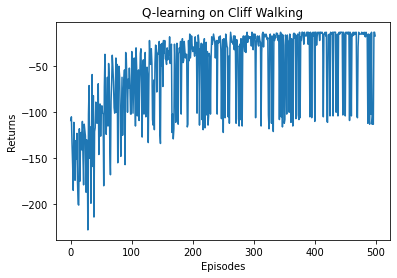

In [35]:
# 初始化环境
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)


# 设置agent
np.random.seed(0)
epsilon = 0.1 
alpha = 0.1 
gamma = 0.9 
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500# 智能体在环境中运行多少条序列

return_list = [] # 记录每一条序列的回报
for i_episode in range(num_episodes):
    episode_return = 0 
    state = env.reset()
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done = env.step(action)
        episode_return += reward    # 这里的会报的计算不计算折扣因子衰减
        agent.update(state, action, reward, next_state)
        state = next_state
    return_list.append(episode_return)
    if (i_episode + 1)%50 == 0:
        print("Episode: {}, Score: {}".format(i_episode+1, np.mean(return_list[-10:])))
        
        
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

## Sarsa
![](https://gitee.com/wubmu/image/raw/master/img/20210824151933.png)

In [32]:
class Sarsa:
    """Sarsa算法"""
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action # 动作个数
        self.alpha = alpha # 学习率
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy策略中的参数
        
    def take_action(self, state): #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    
#     def take_action(self, state, num_episodes): #选取下一步的操作
#         if np.random.random() < self.epsilon * pow(0.95,num_episodes):
#             action = np.random.randint(self.n_action)
#         else:
#             action = np.argmax(self.Q_table[state])
#         return action
    
    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action): # 若两个动作的价值一样，都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Episode: 50, Score: -119.4
Episode: 100, Score: -63.0
Episode: 150, Score: -51.2
Episode: 200, Score: -48.1
Episode: 250, Score: -35.7
Episode: 300, Score: -29.9
Episode: 350, Score: -28.3
Episode: 400, Score: -27.7
Episode: 450, Score: -28.5
Episode: 500, Score: -18.9


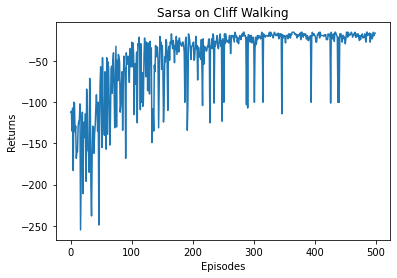

In [34]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 # 智能体在环境中运行多少条序列


return_list = [] # 记录每一条序列的回报
for i_episode in range(num_episodes):
    episode_return = 0 
    state = env.reset()
    done = False
    action = agent.take_action(state)
    while not done:
        
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        
        episode_return += reward    # 这里的会报的计算不计算折扣因子衰减
        
        
        
        agent.update(state, action, reward, next_state, next_action)
        
        state = next_state
        action = next_action
        
    return_list.append(episode_return)
    if (i_episode + 1)%50 == 0:
        print("Episode: {}, Score: {}".format(i_episode+1, np.mean(return_list[-10:])))
        
        
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

## 多步Sarsa算法

![](https://gitee.com/wubmu/image/raw/master/img/20210824155627.png)

In [ ]:
class nstep_Sarsa:
    """n步Sarsa算法"""
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n # 采用n步Sarsa
        
        self.state_list = [] #保存之前的状态
        self.action_list = [] # 保存之前的动作
        self.reward_list = [] # 保存之前的奖励
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state): # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    
    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]